In [20]:
from sklearn.linear_model import (
    LinearRegression,
    RidgeClassifierCV,
    LogisticRegression,
    LogisticRegressionCV,
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
sys.path.append('../')
import data_processing

# Load Data

In [50]:
import numpy as np
from debugging import ipsh

from data_processing import *
np.set_printoptions(precision = 4, suppress = False)

#load dataset
data_name = 'breastcancer'
repo_dir = '../'
data_dir = repo_dir + 'data/'
dataset_file = data_dir + data_name + '/' + data_name + '_processed.RData'
data, cvindices = load_processed_data(dataset_file)
data = add_intercept(data)
data = filter_data_to_fold(data, cvindices)

data = generate_test_data(
    data,
    max_features = 9,
    n_pos = 200,
    n_neg = 200,
    n_conflict = 5,
    remove_duplicates = True
)

In [51]:
X = data['X']
y = data['Y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

In [52]:

# lr = LogisticRegressionCV(Cs=10)
lr = LinearRegression(fit_intercept=False)
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [53]:
beta = lr.coef_[1:] #[0] for logistic
beta_int = lr.coef_[0]
beta

array([ 0.0881,  0.0371,  0.057 ,  0.004 ,  0.006 ,  0.0902,  0.0364,
        0.0405, -0.0082])

In [49]:
# y_pred = lr.predict_proba(X_test)[:, 1] # Logistic Regression
y_pred = lr.predict(X_test) # Linear Regression 

Decision line: 
$$\beta_{int} + \beta_0 * X_{i, 0} + \beta_1 * X_{i, 1} = 0$$
$$X_{i, 0} = \frac{- \beta_1 * X_{i, 1} - \beta_{int}}{\beta_0}$$

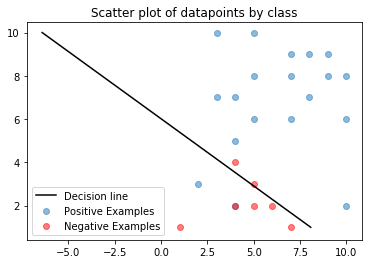

In [21]:
X_1 = np.linspace(X_test[:, 2].min(), X_test[:, 2].max())
X_0 = (-beta[1] * X_1 - beta_int) / beta[0]

neg = np.where(y_test == -1)[0]
pos = np.where(y_test == 1)[0]
plt.scatter(X_test[pos][:, 1], X_test[pos][:, 2], alpha=.5, label='Positive Examples')
plt.scatter(X_test[neg][:, 1], X_test[neg][:, 2], alpha=.5, c='red', label='Negative Examples')
plt.plot(X_0, X_1, label='Decision line', c='black')
plt.legend()
plt.title("Scatter plot of datapoints by class");

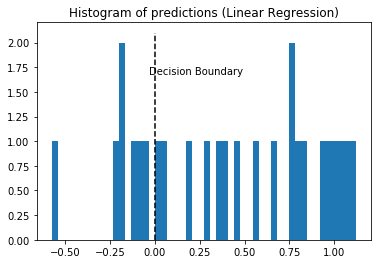

In [22]:
pd.Series(y_pred).hist(bins=50)
plt.title("Histogram of predictions (Linear Regression)")
y_min, y_max = plt.ylim()
plt.vlines(0, y_min, y_max, linestyle="dashed")
plt.text(.49, y_max* .8, "Decision Boundary", horizontalalignment="right")
plt.grid();

In [23]:
roc_auc_score(y_test, y_pred)

0.9135338345864662

OK, so our classifier is reasonable accurate.

# Find flipsets iteratively

Our goal is for $X$ where $f(X) < 0$, find $A$ s.t. $f(X + A) \geq 0$

## Linear Classifier:

We start with $f(X) = \beta X$.

### Base case

__For the case where d = 2:__

$$ f(X) = \beta_{int} + \beta_0 * (X_{i, 0} + a_0) + \beta_1 * (X_{i, 1} + a_1)$$

$A_1 = [0, a_1^{max}]$ is the action set taken when $a_0 = 0$:
$$ a_1^{max} = \frac{- \beta_0 * X_{i, 0} - \beta_{int}}{\beta_1} - X_{i, 1}$$
To generate all integer-flipsets in the 2-dim case, step up towards the max:

For $a_1^{step}$ in $0,1,...,a_1^{max}$:

$$f(x + a) = -C_1 + \beta_0 * (X_{i, 0} + a_0)$$
$$0 = -C_1 + \beta_0 * (X_{i, 0} + a_0)$$

where $$C_1 = -\beta_{int} - \beta_1 * (X_{i, 1} + a_1^{step})$$

Solve for $a_0$:

$$ a_0 = \frac{C_1}{\beta_0} - X_{i, 0}$$

## Generalize

__For the case where d = 3:__

$$ f(X) = \beta_{int} + \beta_0 * (X_{i, 0} + a_0) + \beta_1 * (X_{i, 1} + a_1) + \beta_2 * (X_{i, 2} + a_2)$$

$A_2 = [0, 0, a_2^{max}]$ is the action set taken when $a_0, a_1 = 0$

For $a_2^{step}$ in $0, 1, ..., a_2^{max}$:

set
$$0 = - C_2 + \beta_{int} + \beta_1 * (X_{i, 1} + a_1) + \beta_0 * (X_{i, 0} + a_0)$$
where 
$$C_2 = - \beta_2 * (X_{i, 2} + a_2^{step})$$

Solve for $a_1^{max}$ by setting $a_0 = 0$:

$$0 = - C_2 + \beta_{int} + \beta_1 * (X_{i, 1} + a_1^{max}) + \beta_0 * X_{i, 0}$$
$$a_1^{max} = \frac{C_2 - \beta_0 * X_{i, 0} - \beta_{int}}{\beta_1} - X_{i, 1}$$

Find $a_1^{max}$ and go through the steps as in the 2-d case, except the left side of the equation is set to $C_2$ instead of $0$...

__For the case where d = k:__

$$f(x) = \beta_{int} + \beta_0(x_0 + a_0) + ... + \beta_i(x_i + a_i) + ... + \beta_k(x_k + a_k)$$

Define:

* $C_i(a_i) = \beta_i (X_i + a_i)$
* $a_i^0 = \min a_i$ (can be 5th percentile observed, min, or 0)

Find $a_k^{max}$: $$a_k^{max} = -X_k - \frac{(\beta_{int} + \sum_{i=0}^{k-1} C_i(a_i^0))}{\beta_k}$$

For $a_k^{step} = 0, ..., a_k^{max}$:

  Find $a_{j=k-1}^{max}$
$$a_{j}^{max} = \frac{-X_j - (\beta_{int} + \sum_{i=0}^{j-1}C_i(a_i^0) + \sum_{i=j+1}^{k}C_i(a_i^{step} ))}{\beta_j}$$

Repeat for $j = 1, ..., k-1$

In [ ]:
# min, max change in each direction (find user min and max)
# cost of stepping in that direction: 
# names of variables that cannot be changed

# or, call something a certain type (integer, float, boolean)
# everything is greedy. You start off with a certain score. Pick the cheapest change.

# 1. implemenet bounding functionality (may or may not work).
# 2. have the ability to reduce the bounds.
# 3. when you rule out steps in different directions, certain points won't have a flipset.
# 4. 

# goal: can you fit a classifier where certain points have a non-empty flipset.
# add conservative variable bounds. prevent changing things that can't be changed.
# 

# train an SVM classifier
# with a parameter that controls the width of the margin
# as the error term becomes more important, SVM pushes points away from the decision boundary
# once you add steps in certain dimensions, you should find a dataset where SVM doesn't provide
# a flip set for everyone. at that point, if that doesn't work out, you have to reduce the boundaries.
# then we have to find a 

In [33]:
import copy
class FlipSet():
    def __init__(self, x, beta, beta_int):
        self.decision_boundary=.5
        self.x = x
        self.k = len(x)
        self.A_set = []
        self.beta = beta
        self.beta_int = beta_int
                
    def get_a_j_max(self, a_step, j):        
        s1 = sum(self.beta[i] * (self.x[i] + 0) for i in range(0, j))
        s2 = sum(self.beta[i] * (self.x[i] + a_step[i - (j+1)]) for i in range(j+1, self.k))
        return - self.x[j] - (self.beta_int + s1 + s2 ) / self.beta[j]
    
    def rounder(self, j):
        # TODO
        beta_sign = np.sign(self.beta[j])
        rounder = np.ceil
        if beta_sign == -1:
            rounder = np.floor
#         return rounder
        return lambda x: x

    def get_flip_set(self, j=None, a_step_set=None):
        if j == None:
            j = self.k-1
            a_step_set = []
        
        a_j_max = self.get_a_j_max(a_step_set, j)
        
        if j == 0:
            # break recursion
            action_set = [self.rounder(j)(a_j_max)] + a_step_set
            self.A_set.append(action_set)
            return
        
        sign = np.sign(a_j_max)
        for a_j_step in np.arange(0, a_j_max+sign, step=sign):
            a_step_instance = [a_j_step] + copy.copy(a_step_set) 
            self.get_flip_set(j - 1, a_step_instance)


In [56]:
y_pred[1]

-1.0987890754793024

In [58]:
x_i = X_test[1][1:]
f = FlipSet(x_i, beta=beta, beta_int=beta_int)

In [60]:
f.get_flip_set()

KeyboardInterrupt: 

In [ ]:
len(f.A_set)

In [ ]:
for a in f.A_set[:20]:
    print beta_int + sum((x_i[i] + a[i]) * beta[i] for i in range(4))